## First contact with dense_basis and the GP-SFH module:

Creating different shapes using SFH-tuples

In [1]:
import numpy as np
import dense_basis as db
import matplotlib.pyplot as plt

Starting dense_basis. Failed to load FSPS, only GP-SFH module will be available.


In [5]:
Nparam = 1
redshift = 0.0
logMstar = 10.0

Let’s start with an SFH that is rising throughout a galaxy’s lifetime, such as may be expected for high-redshift star forming galaxies. Since we are considering a galaxy with 𝑀∗=10^10𝑀⊙

Since the SFR is rising, we also choose a short t50, since it is rapidly building forming its stars. Running this through the model, we get:

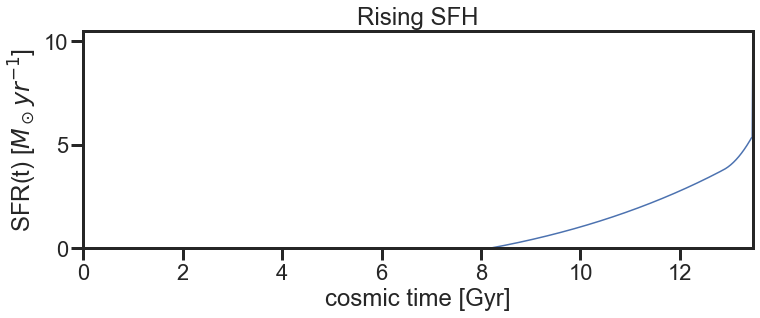

[ 0.          0.01348046  0.02696093  0.04044139  0.05392186  0.06740232
  0.08088279  0.09436325  0.10784372  0.12132418  0.13480464  0.14828511
  0.16176557  0.17524604  0.1887265   0.20220697  0.21568743  0.22916789
  0.24264836  0.25612882  0.26960929  0.28308975  0.29657022  0.31005068
  0.32353115  0.33701161  0.35049207  0.36397254  0.377453    0.39093347
  0.40441393  0.4178944   0.43137486  0.44485533  0.45833579  0.47181625
  0.48529672  0.49877718  0.51225765  0.52573811  0.53921858  0.55269904
  0.56617951  0.57965997  0.59314043  0.6066209   0.62010136  0.63358183
  0.64706229  0.66054276  0.67402322  0.68750368  0.70098415  0.71446461
  0.72794508  0.74142554  0.75490601  0.76838647  0.78186694  0.7953474
  0.80882786  0.82230833  0.83578879  0.84926926  0.86274972  0.87623019
  0.88971065  0.90319112  0.91667158  0.93015204  0.94363251  0.95711297
  0.97059344  0.9840739   0.99755437  1.01103483  1.0245153   1.03799576
  1.05147622  1.06495669  1.07843715  1.09191762  1.

In [3]:
logSFR = 1.0
t50 = 0.6 # t50, lookback time, in Gyr

sfh_tuple = np.hstack([logMstar, logSFR, Nparam, db.scale_t50(t50,redshift)])
sfh, timeax = db.tuple_to_sfh(sfh_tuple, redshift) #timeax in Gyr, SFH in Msun/Yr

fig = db.plot_sfh(timeax, sfh, lookback=False) #notice if lookback or cosmic time
plt.title('Rising SFH')
plt.show()

#notice the SFH is limited in age because of the selected redshift

print(timeax)

Check https://dense-basis.readthedocs.io/en/latest/tutorials/the_gp_sfh_module.html for getting more prototype SFHs

In [ ]:
print(sfh)
print(timeax)

Let's get random SFHs (because I don't want to select always the parameters).


The next step is to generate a template atlas that you will use for fitting. The advantage of doing this is that we trade time-complexity for space, which is usually much more abundant, and it only needs to be done once to fit a large dataset. Before doing this, however, we need a set of priors that we can draw from to generate this atlas. This is done using the db.Priors() class:

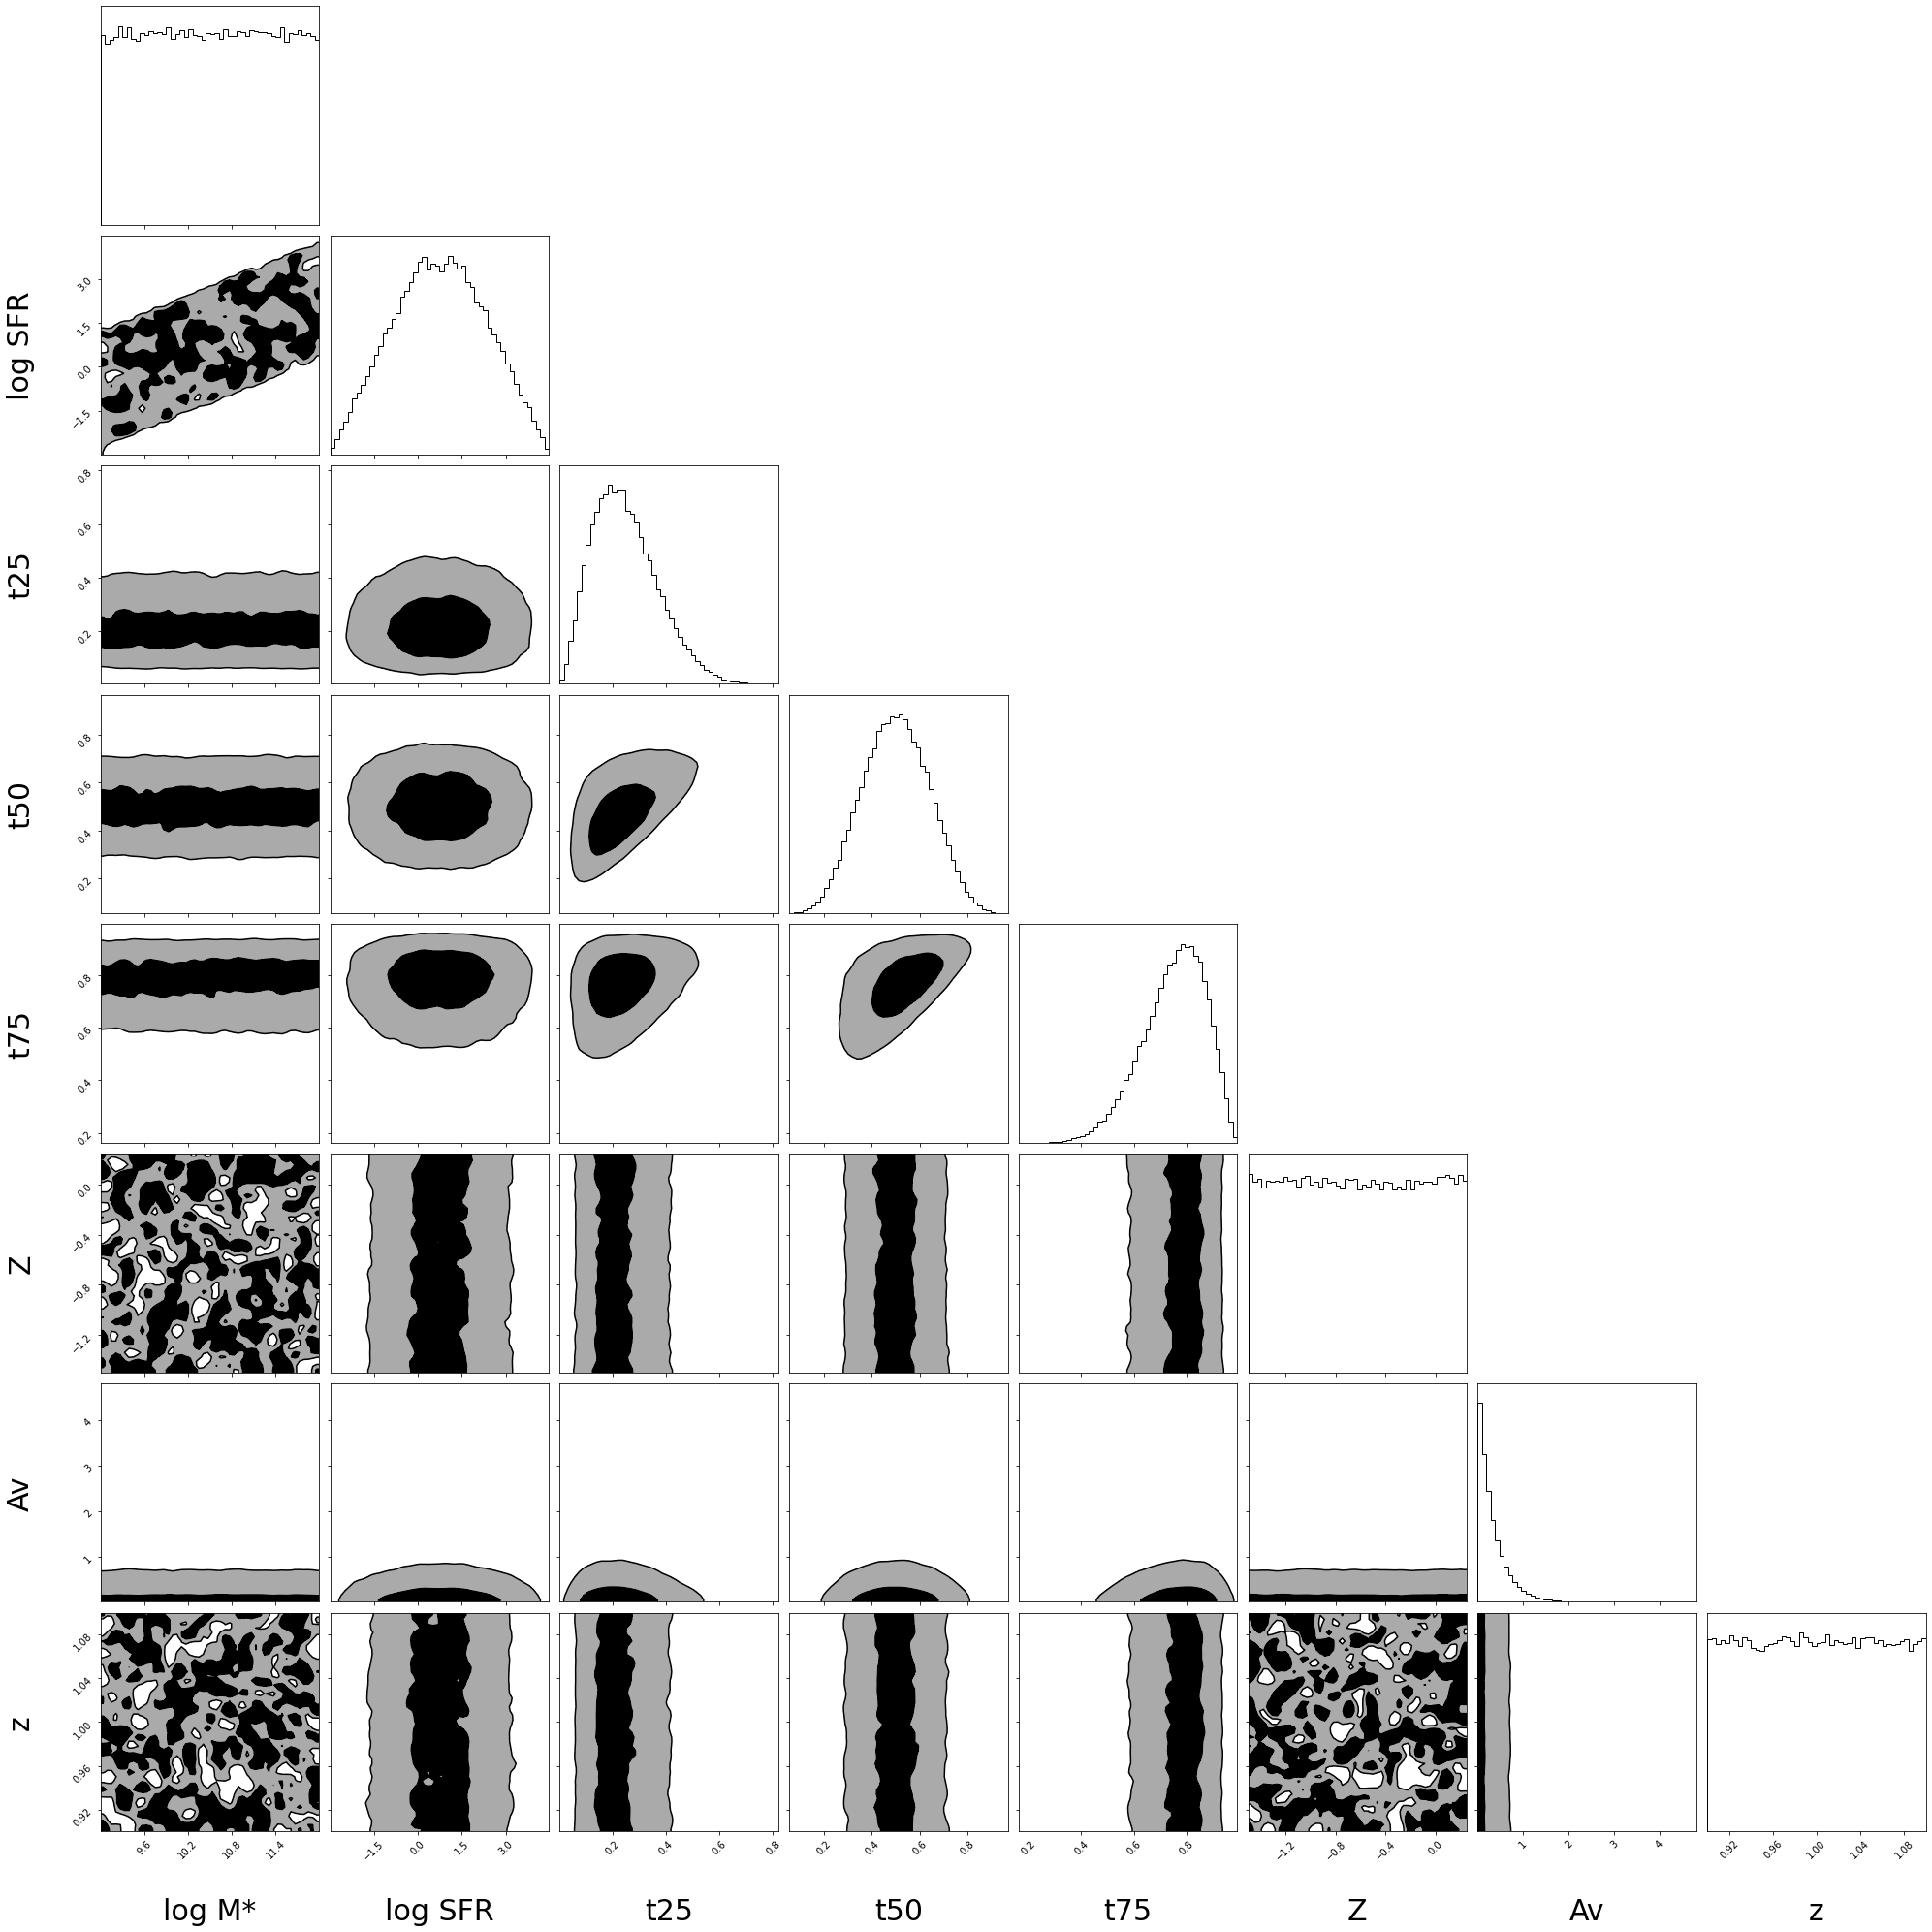

In [11]:
priors = db.Priors()
priors.tx_alpha = 3.0 
priors.plot_prior_distributions()


#tx : lookback times at which a galaxy formed certain fractions of its mass
#concentration (tx_alpha) and number of parameters (Nparam) of distribution

Let’s generate a mock star formation history (SFH) to recover. This can be done by sampling our priors for an SFH-tuple and then converting it to a SFR-vs-time curve using the db.tuple_to_sfh() command.

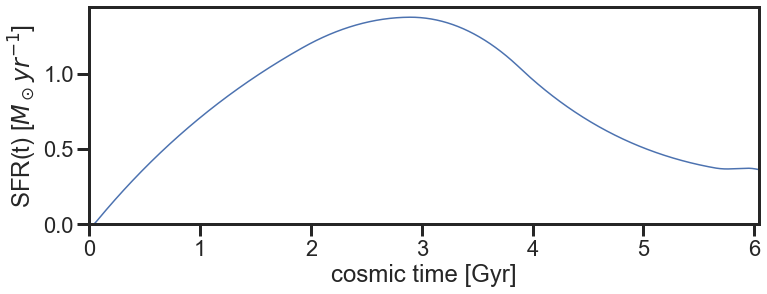

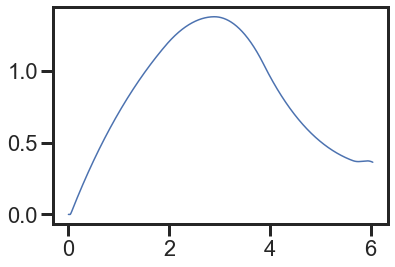

In [16]:
# sample from the prior space to get parameters
rand_sfh_tuple, rand_Z, rand_Av, rand_z = priors.sample_all_params(random_seed = np.random.randint(1000))

# generate an SFH corresponding to the SFH-tuple and see how it looks:

rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = rand_z)
fig = db.plot_sfh(rand_time, rand_sfh, lookback=False)
sfh_truths = [rand_time, rand_sfh]
plt.show()

plt.plot(rand_time, rand_sfh)

We do not care about metallicity. This would be included in the spectra given by MILES, not in the SFH.

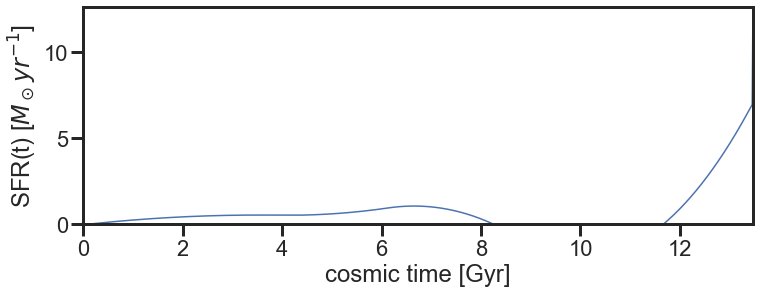

In [75]:
# sample from the prior space to get tuple
rand_sfh_tuple=priors.sample_sfh_tuple()
rand_sfh_tuple[0]=10.0 #logMstar at selected z (in this case z=0)
rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = 0.0) 
fig = db.plot_sfh(rand_time, rand_sfh, lookback=False) #notice max age is 13.5 Gyrs
sfh_truths = [rand_time, rand_sfh]

In [76]:
#print(rand_sfh,rand_time)

print(format(np.sum(rand_sfh)*(rand_time[1]-rand_time[0])*10**9,'1E'))
#notice we are doing Msun/Yr * Gyr * 1e9 so we obtain Msun
#we check the total stellar mass at z=0 is 10**10 (as in our parametric SFHs)

#we confirm the time steps are always the same
print(rand_time[1]-rand_time[0],rand_time[2]-rand_time[1],rand_time[100]-rand_time[99])

1.020915E+10
0.01348046441147335 0.01348046441147335 0.013480464411473214


Let's see if we can get the percentiles (notice we have to change the step of ages and the unit in the SFR). We can fix the mass of the non parametric SFHs and the redshift, but it is not recommended: we want to avoid priors in our training set.

In [61]:
import astropy.units as u
from astropy.cosmology import  Planck13,z_at_value



def z_cosmic(t):
    #receives cosmic time, returns redshit
    return z_at_value(Planck13.age,t*u.Gyr).value

def t_cosmic(z):
    #receives redsfit, returns cosmic time
    return (Planck13.age(0)-Planck13.lookback_time(z)).value


def sample_z_prior(zmin,zmax,size=1):
        #if uniform, like in dense_basis, not uniformly_distributed in time
        #zval = np.random.uniform(size=size)*(z_max-z_min) + z_min
        tmax=t_cosmic(zmax)
        tmin=t_cosmic(zmin)
        tval=np.random.uniform(size=size)*(tmax-tmin) + tmin
        zval=z_cosmic(tval)
        return zval


def generate_weights_from_SFHs_non_param(n,percen=True):

    priors = db.Priors()
    curves=[]
    times=[] #needed because rand_time length and step depends on the redshift

    #priors.mass_max = 16.0
    #priors.mass_min = 14.0

    #priors.sfr_max = 0.5
    #priors.sfr_min = -3.0

    z=np.zeros((n,)) #present time

    for i in range(n):
        rand_sfh_tuple=priors.sample_sfh_tuple()
        rand_sfh_tuple[0]=16
        rand_sfh_tuple[1]=-3.0
        rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = z[i]) 
        curves.append(rand_sfh*1e9) #conversion from Msun/yr to Msun/Gyr
        times.append(rand_time)

    ms=[]
    #non accumulative mass curves, we save it cause we will use it later
    for index,curve in enumerate(curves):        
        sfr_0=curve
        m=[]
        t=times[index]
        #print(t)
        step=t[1]-t[0]
        #print(step)
        for i,tx in enumerate(t):  
             m_t=sfr_0[i]*step #this gives directly the mass curve (non accumulative)
             m.append(m_t)
        ms.append(m/np.sum(m)) #normalized (weigths!!)

    if percen:
        #compute percentiles
        percentiles=[]
        for i,curve in enumerate(curves):
             mcurve=ms[i]
             m=[]
             percent=[]
             for j in range(len(mcurve)):
                m.append(np.sum(mcurve[:j+1]))
             for k in range(1,10):
                ind=np.argmin(abs(np.array(m)-k/10))
                percent.append(times[i][ind])
             percentiles.append(percent)  
        return np.array(times),np.array(ms),np.array(percentiles)
    else:
        return np.array(times),np.array(ms)

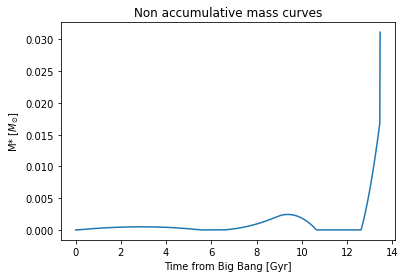

1.0


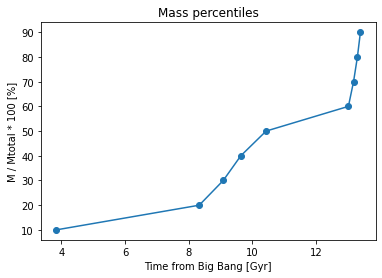

1000


In [41]:
n=1
t,ms,percentiles=generate_weights_from_SFHs_non_param(n)

for i in range(n):
    plt.plot(t[i,:],ms[i,:])
    plt.title('Non accumulative mass curves')
    plt.ylabel('M* [$M_{\\odot}$]')
    plt.xlabel('Time from Big Bang [Gyr]')
    plt.show()
    print(np.sum(ms[i,:]))
    plt.plot(percentiles[i,:],np.arange(10,100,10),'-o')
    plt.title('Mass percentiles')
    plt.xlabel('Time from Big Bang [Gyr]')
    plt.ylabel('M / Mtotal * 100 [%]')
    plt.show()

print(len(t[0]))

Now we are ready to check how are models trained with parametric SFHs work with these little babies. Probably not really well, but next step will be to train our model with them so it gets much more flexible.

Try to balance the dataset to get as many old galaxies as young ones

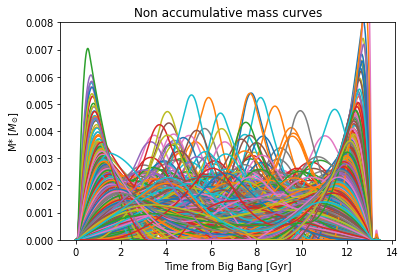

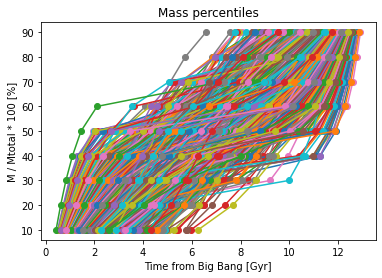

In [63]:
n=1000
t,ms,percentiles=generate_weights_from_SFHs_non_param(n) #random mass

for i in range(n):
    plt.plot(t[i,:],ms[i,:])
plt.title('Non accumulative mass curves')
plt.ylabel('M* [$M_{\\odot}$]')
plt.xlabel('Time from Big Bang [Gyr]')
plt.ylim(0,0.008)
plt.show()

for i in range(n):
    plt.plot(percentiles[i,:],np.arange(10,100,10),'-o')
plt.title('Mass percentiles')
plt.xlabel('Time from Big Bang [Gyr]')
plt.ylabel('M / Mtotal * 100 [%]')
plt.show()

